In [90]:
import os, os.path as op, pandas as pd, numpy as np
from glob import glob
import seaborn as sns
u = lambda x: list(set(x))
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set()

In [74]:
tasks = u([e.split("-")[-1].split(".")[0] for e in glob("data/tp-1/*.log")])
tasks = [t for t in tasks if "FinTapp" not in t]
participants = u([op.split(e)[-1].split('-')[0] for e in glob("data/tp-1/*.log")])

In [75]:
participants

['BISAM114',
 'BISAM102',
 'BISAM105',
 'BISAM115',
 'BISAM112',
 'BISAM113',
 'BISAM103',
 'BISAM111',
 'BISAM109',
 'BISAM110',
 'BISAM101']

In [8]:
tasks

['DD6Mixed', 'LDTVisBra', 'LDTTactBra', 'FinTapp', 'LDTVisL1']

In [125]:
def tryconvert(value, default, if_error):
    try:
        return default(value)
    except (ValueError, TypeError):
        return if_error

In [195]:
t = "LDTVisL1"

dGroup = {"participant":[], "block":[], "percentage":[]}

for p in participants:
    f = [e for e in glob("data/tp-1/*.log") if t in e if p in e][0]

    d = pd.read_csv(f, skiprows=3, sep = "\t")
    d.columns = [c.lower() for c in list(d.columns)]
    d = d[d.subject == d.subject[0]]
    d = d[((d["event type"] == "Response") & (d["code"] != "3")) | (d["code"].str.contains(t))].reset_index(drop=True)

    stimIndices = np.array(d[d.code.str.contains("LDTVisL1")].index)

    d2 = pd.DataFrame(data={"word":[d.code[i] for i in np.array(d[d.code.str.contains(t)].index)],
     "participantAnswer":[tryconvert(d.code[i+1], int, np.nan) for i in np.array(d[d.code.str.contains(t)].index)]})
    d2["corrAns"] = d2["word"].apply(lambda x: x.split("-")[-1]).map({"w":1,"p":2,"t":1,"n":2})
    d2["blockType"] = d2["word"].apply(lambda x: "experimental" if (x.split("-")[-1] == "w" or x.split("-")[-1] == "p")
                                      else "control" )
    d2["stimType"] = d2["word"].apply(lambda x: "word" if x.split("-")[-1] == "w" else
                                         ("pseudoword" if x.split("-")[-1] == "p" else
                                          ("hash" if x.split("-")[-1] == "t" else "no hash")))
    d2["participantCorrect"] = (d2["corrAns"] == d2["participantAnswer"]).astype(int)*100
    d2_stat = d2.groupby(['blockType'])['participantCorrect'].mean().reset_index()
    fig = sns.barplot(x = 'blockType', y = 'participantCorrect', data = d2_stat, order = ['experimental','control'])
    plt.xlabel("Block")
    plt.ylabel("Percentage of correct answers")
    plt.ylim([0,105])
    #plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
    plt.yticks(range(0,101,10))
    #plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
    plt.title(f"{p} - {t}") # You can comment this line out if you don't need title
    fig.yaxis.set_major_formatter(mtick.PercentFormatter())
    #fig.get_legend().remove()
    plt.savefig(f"{p}_{t}.png",dpi=300)
    #plt.show(fig)
    plt.close()
    dGroup["participant"].extend([p,p])
    dGroup["block"].extend(list(d2_stat.blockType))
    dGroup["percentage"].extend(list(d2_stat.participantCorrect))
dGroup = pd.DataFrame(dGroup)
dGroup["day"] = dGroup["participant"].apply(lambda x: "Monday" if 101 <= int(x.split("BISAM")[-1]) <= 105 else
                           ("Tuesday" if 106 <= int(x.split("BISAM")[-1]) <= 110 else
                           ("Wednesday" if 111 <= int(x.split("BISAM")[-1]) <= 115 else "x")))

fig = sns.barplot(x = 'block', y = 'percentage',
                  data = dGroup.groupby("block")["percentage"].mean().reset_index(),
                  order = ['experimental','control'])
plt.xlabel("Block")
plt.ylabel("Percentage of correct answers")
plt.ylim([0,105])
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.yticks(range(0,101,10))
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.title(f"All participants (mean) - {t}") # You can comment this line out if you don't need title
fig.yaxis.set_major_formatter(mtick.PercentFormatter())
#fig.get_legend().remove()
plt.savefig(f"mean_{t}.png",dpi=300)
#plt.show(fig)
plt.close()

In [218]:
dGroup["day"] = dGroup["participant"].apply(lambda x: "Monday" if 101 <= int(x.split("BISAM")[-1]) <= 105 else
                           ("Tuesday" if 106 <= int(x.split("BISAM")[-1]) <= 110 else
                           ("Wednesday" if 111 <= int(x.split("BISAM")[-1]) <= 115 else "x")))

In [219]:
dGroup

,participant,block,percentage,day
0,BISAM114,control,87.5,Wednesday
1,BISAM114,experimental,30.0,Wednesday
2,BISAM102,control,90.0,Monday
3,BISAM102,experimental,45.0,Monday
4,BISAM105,control,95.0,Monday
5,BISAM105,experimental,52.5,Monday
6,BISAM115,control,100.0,Wednesday
7,BISAM115,experimental,55.0,Wednesday
8,BISAM112,control,95.0,Wednesday
9,BISAM112,experimental,50.0,Wednesday


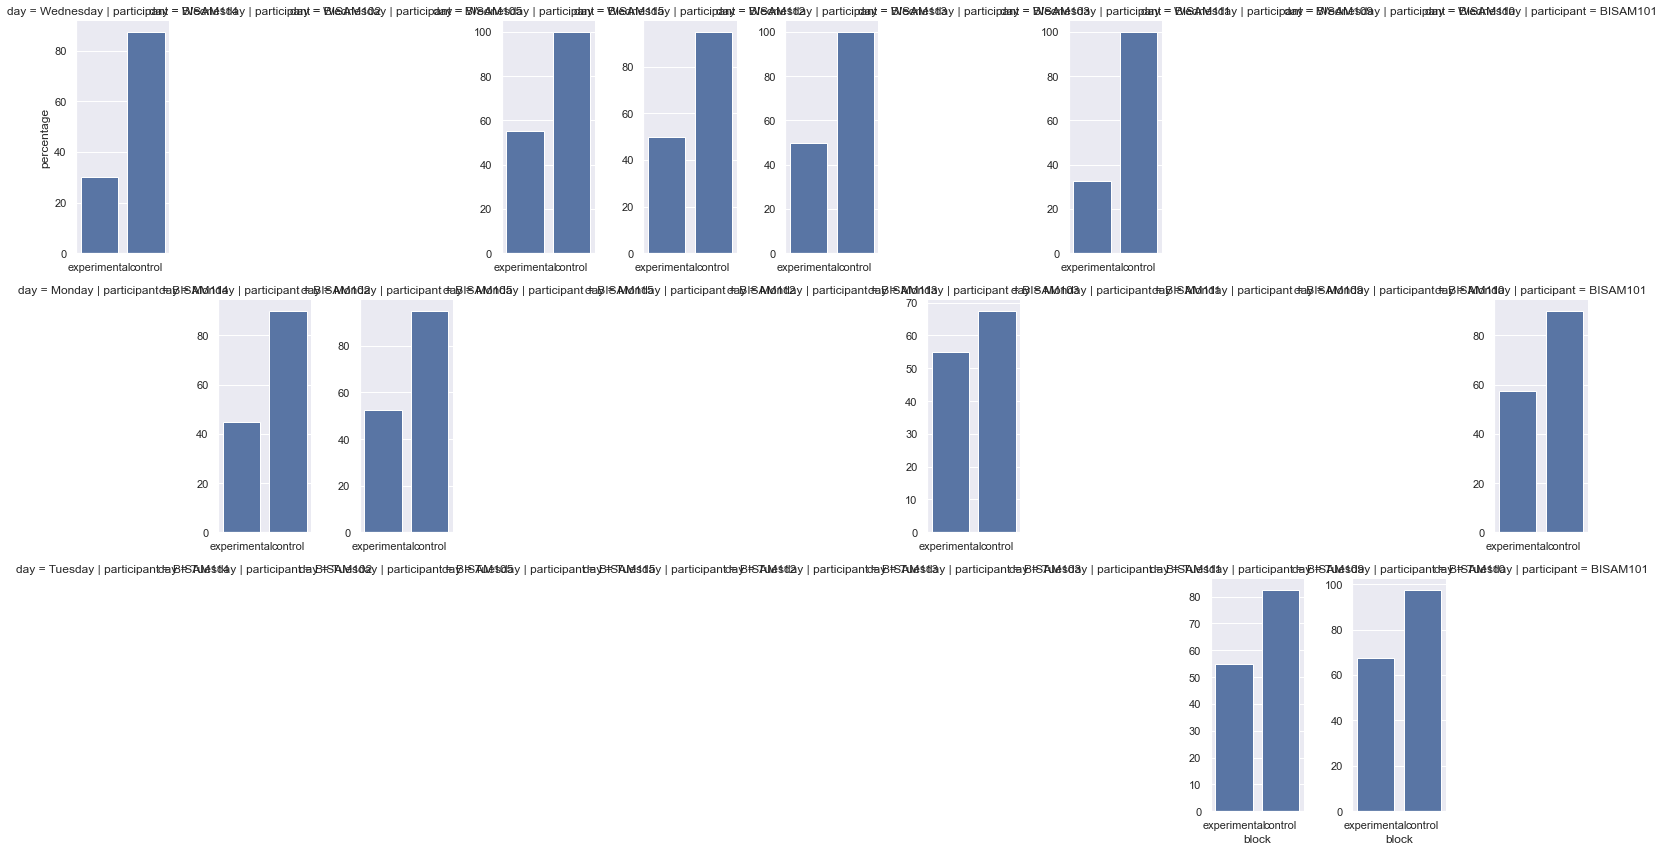

In [226]:
g = sns.FacetGrid(dGroup, row="day",col="participant", height=4, aspect=.5,sharex=False, sharey=False)
g.map(sns.barplot,'block', 'percentage', order=['experimental','control'])
for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()

In [207]:
dGroup

,participant,block,percentage
0,BISAM114,control,87.5
1,BISAM114,experimental,30.0
2,BISAM102,control,90.0
3,BISAM102,experimental,45.0
4,BISAM105,control,95.0
5,BISAM105,experimental,52.5
6,BISAM115,control,100.0
7,BISAM115,experimental,55.0
8,BISAM112,control,95.0
9,BISAM112,experimental,50.0


In [193]:
dGroup.groupby("block")["percentage"].mean().reset_index()

,block,percentage
0,control,98.863636
1,experimental,99.545455


In [191]:
pd.DataFrame(dGroup)

,participant,block,percentage
0,BISAM114,control,100.0
1,BISAM114,experimental,100.0
2,BISAM102,control,100.0
3,BISAM102,experimental,97.5
4,BISAM105,control,100.0
5,BISAM105,experimental,100.0
6,BISAM115,control,100.0
7,BISAM115,experimental,100.0
8,BISAM112,control,100.0
9,BISAM112,experimental,100.0


In [188]:
list(d2_stat.blockType)

['control', 'experimental']

In [197]:

dGroup = {"participant":[], "block":[], "percentage":[]}

t = "LDTVisBra"

for p in participants:
    f = [e for e in glob("data/tp-1/*.log") if t in e if p in e][0]

    d = pd.read_csv(f, skiprows=3, sep = "\t")
    d.columns = [c.lower() for c in list(d.columns)]
    d = d[d.subject == d.subject[0]]
    d = d[((d["event type"] == "Response") & (d["code"] != "3")) | (d["code"].str.contains(t))].reset_index(drop=True)

    stimIndices = np.array(d[d.code.str.contains("LDTVisL1")].index)

    d2 = pd.DataFrame(data={"word":[d.code[i] for i in np.array(d[d.code.str.contains(t)].index)],
     "participantAnswer":[tryconvert(d.code[i+1], int, np.nan) for i in np.array(d[d.code.str.contains(t)].index)]})
    d2["corrAns"] = d2["word"].apply(lambda x: x.split("-")[-1]).map({"w":1,"p":2,"y":1,"n":2})
    d2["blockType"] = d2["word"].apply(lambda x: "experimental" if (x.split("-")[-1] == "w" or x.split("-")[-1] == "p")
                                      else "control" )
    d2["stimType"] = d2["word"].apply(lambda x: "word" if x.split("-")[-1] == "w" else
                                         ("pseudoword" if x.split("-")[-1] == "p" else
                                          ("hash" if x.split("-")[-1] == "y" else "no hash")))
    d2["participantCorrect"] = (d2["corrAns"] == d2["participantAnswer"]).astype(int)
    d2_stat = d2.groupby(['blockType'])['participantCorrect'].mean().reset_index()
    d2_stat["participantCorrect"] *= 100
    fig = sns.barplot(x = 'blockType', y = 'participantCorrect', data = d2_stat, order = ['experimental','control'])
    plt.xlabel("Block")
    plt.ylabel("Percentage of correct answers")
    plt.ylim([0,105])
    #plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
    plt.yticks(range(0,101,10))
    plt.title(f"{p} - {t}") # You can comment this line out if you don't need title
    fig.yaxis.set_major_formatter(mtick.PercentFormatter())
    #fig.get_legend().remove()
    plt.savefig(f"{p}_{t}.png",dpi=300)
    plt.close()
    #plt.show(fig)
    dGroup["participant"].extend([p,p])
    dGroup["block"].extend(list(d2_stat.blockType))
    dGroup["percentage"].extend(list(d2_stat.participantCorrect))
dGroup = pd.DataFrame(dGroup)

fig = sns.barplot(x = 'block', y = 'percentage',
                  data = dGroup.groupby("block")["percentage"].mean().reset_index(),
                  order = ['experimental','control'])
plt.xlabel("Block")
plt.ylabel("Percentage of correct answers")
plt.ylim([0,105])
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.yticks(range(0,101,10))
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.title(f"All participants (mean) - {t}") # You can comment this line out if you don't need title
fig.yaxis.set_major_formatter(mtick.PercentFormatter())
#fig.get_legend().remove()
plt.savefig(f"mean_{t}.png",dpi=300)
#plt.show(fig)
plt.close()
    
    

In [205]:

dGroup = {"participant":[], "block":[], "percentage":[]}

t = "LDTTactBra"

for p in participants:
    f = [e for e in glob("data/tp-1/*.log") if t in e if p in e][0]

    d = pd.read_csv(f, skiprows=3, sep = "\t")
    d.columns = [c.lower() for c in list(d.columns)]
    d = d[d.subject == d.subject[0]]
    d = d[((d["event type"] == "Response") & (d["code"] != "3")) | (d["code"].str.contains(t))].reset_index(drop=True)

    stimIndices = np.array(d[d.code.str.contains("LDTVisL1")].index)

    d2 = pd.DataFrame(data={"word":[d.code[i] for i in np.array(d[d.code.str.contains(t)].index)],
     "participantAnswer":[tryconvert(d.code[i+1], int, np.nan) for i in np.array(d[d.code.str.contains(t)].index)]})
    d2["corrAns"] = d2["word"].apply(lambda x: x.split("-")[-1]).map({"w":1,"p":2,"t":1,"n":2})
    d2["blockType"] = d2["word"].apply(lambda x: "experimental" if (x.split("-")[-1] == "w" or x.split("-")[-1] == "p")
                                      else "control" )
    d2["stimType"] = d2["word"].apply(lambda x: "word" if x.split("-")[-1] == "w" else
                                         ("pseudoword" if x.split("-")[-1] == "p" else
                                          ("hash" if x.split("-")[-1] == "t" else "no hash")))
    d2["participantCorrect"] = (d2["corrAns"] == d2["participantAnswer"]).astype(int)
    d2_stat = d2.groupby(['blockType'])['participantCorrect'].mean().reset_index()
    d2_stat["participantCorrect"] *= 100
    fig = sns.barplot(x = 'blockType', y = 'participantCorrect', data = d2_stat, order = ['experimental','control'])
    plt.xlabel("Block")
    plt.ylabel("Percentage of correct answers")
    plt.ylim([0,105])
    #plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
    plt.yticks(range(0,101,10))
    plt.title(f"{p} - {t}") # You can comment this line out if you don't need title
    fig.yaxis.set_major_formatter(mtick.PercentFormatter())
    #fig.get_legend().remove()
    plt.savefig(f"{p}_{t}.png",dpi=300)
    plt.close()
    #plt.show(fig)
    dGroup["participant"].extend([p,p])
    dGroup["block"].extend(list(d2_stat.blockType))
    dGroup["percentage"].extend(list(d2_stat.participantCorrect))
dGroup = pd.DataFrame(dGroup)

fig = sns.barplot(x = 'block', y = 'percentage',
                  data = dGroup.groupby("block")["percentage"].mean().reset_index(),
                  order = ['experimental','control'])
plt.xlabel("Block")
plt.ylabel("Percentage of correct answers")
plt.ylim([0,105])
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.yticks(range(0,101,10))
#plt.xticks([0,1,2,3],labels=["word", "pseudoword", "hash", "no hash"])
plt.title(f"All participants (mean) - {t}") # You can comment this line out if you don't need title
fig.yaxis.set_major_formatter(mtick.PercentFormatter())
#fig.get_legend().remove()
plt.savefig(f"mean_{t}.png",dpi=300)
#plt.show(fig)
plt.close()
    
    

In [206]:
d2

,word,participantAnswer,corrAns,blockType,stimType,participantCorrect
0,ses-tp-1_task-LDTTactBra_word-sema_corrans-p,1.0,2,experimental,pseudoword,0
1,ses-tp-1_task-LDTTactBra_word-typu_corrans-w,2.0,1,experimental,word,0
2,ses-tp-1_task-LDTTactBra_word-stek_corrans-w,1.0,1,experimental,word,1
3,ses-tp-1_task-LDTTactBra_word-liłcu_corrans-p,1.0,2,experimental,pseudoword,0
4,ses-tp-1_task-LDTTactBra_word-topi_corrans-w,2.0,1,experimental,word,0
...,...,...,...,...,...,...
75,ses-tp-1_task-LDTTactBra_word-##lł_corrans-t,1.0,1,control,hash,1
76,ses-tp-1_task-LDTTactBra_word-lm#m#_corrans-t,1.0,1,control,hash,1
77,ses-tp-1_task-LDTTactBra_word-m##_corrans-t,1.0,1,control,hash,1
78,ses-tp-1_task-LDTTactBra_word-dkłkł_corrans-n,2.0,2,control,no hash,1


In [202]:
u(d.code.apply(lambda x: x.split("-")[-1]))

['1', 'w', 'n', '2', 'p', 't']